In [ ]:
pip install pandas

In [ ]:
pip install requests


In [ ]:
pip install beautifulsoup4

In [ ]:
pip install tabulate

In [ ]:
pip install spotipy

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify API credentials
client_id = "22042623eef94773b216ea84da01c375"
client_secret = "482f466fc8224a768054314b6543c939"

# Spotify API authentication
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Year range
start_year = 1992
end_year = 2022

# Create lists to store the extracted information
all_ranks = []
all_titles = []
all_artists = []
all_genres = []
all_audio_features = []
all_years = []

# Iterate over the years
for year in range(start_year, end_year + 1):
    if year != 2016:  # Exclude the year 2016
        # URL for the specific year
        url = f"https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_{year}"

        # Send a GET request to the URL
        response = requests.get(url)

        # Create a BeautifulSoup object from the HTML content
        soup = BeautifulSoup(response.text, "html.parser")

        # Find all tables in the page
        tables = soup.find_all("table", class_="wikitable")

        # Process each table
        for table in tables:
            # Create lists to store the extracted information for the current table
            ranks = []
            titles = []
            artists = []
            genres = []
            audio_features = []

            # Extract the data from the table rows
            rows = table.find_all("tr")[1:]  # Exclude the header row
            for row in rows:
                cells = row.find_all("td")
                rank = cells[0].text.strip()
                title = cells[1].text.strip()
                artist = cells[2].text.strip()

                ranks.append(rank)
                titles.append(title)
                artists.append(artist)

                # Search for the artist on Spotify
                results = sp.search(q=artist, type="artist", limit=1)

                if results["artists"]["items"]:
                    artist_info = results["artists"]["items"][0]
                    artist_genres = artist_info["genres"] if "genres" in artist_info else []
                    genres.append(artist_genres)
                else:
                    genres.append([])

                # Search for the track on Spotify
                query = f"{title} {artist}"
                results = sp.search(q=query, type="track", limit=1)

                if results["tracks"]["items"]:
                    track = results["tracks"]["items"][0]
                    track_id = track["id"]
                    audio_feature = sp.audio_features([track_id])[0]

                    audio_features.append(audio_feature)
                else:
                    audio_features.append({})

            # Append the extracted information to the respective lists
            all_ranks.extend(ranks)
            all_titles.extend(titles)
            all_artists.extend(artists)
            all_genres.extend(genres)
            all_audio_features.extend(audio_features)
            all_years.extend([year] * len(ranks))

# Create a DataFrame using the extracted information
data = {
    "Year": all_years,
    "Rank": all_ranks,
    "Title": all_titles,
    "Artist": all_artists,
    "Genres": all_genres,
    "Audio Features": all_audio_features
}
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv("billboard_hot100_years_genres_audio_features.csv", index=False)

# Save the DataFrame to an Excel file
df.to_excel("billboard_hot100_years_genres_audio_features.xlsx", index=False)


      Year Rank                       Title                          Artist  \
0     1992    1           "End of the Road"                     Boyz II Men   
1     1992    2             "Baby Got Back"                   Sir Mix-a-Lot   
2     1992    3                      "Jump"                      Kris Kross   
3     1992    4    "Save the Best for Last"                Vanessa Williams   
4     1992    5            "Baby-Baby-Baby"                             TLC   
...    ...  ...                         ...                             ...   
2995  2022   96              "Flower Shops"  Ernest featuring Morgan Wallen   
2996  2022   97               "To the Moon"       Jnr Choi and Sam Tompkins   
2997  2022   98                    "Unholy"        Sam Smith and Kim Petras   
2998  2022   99           "One Mississippi"                      Kane Brown   
2999  2022  100  "Circles Around This Town"                    Maren Morris   

                                                 Ge

In [ ]:
pip install matplotlib

In [ ]:
pip install plotly

<ipython-input-136-44407aa7d503>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-136-44407aa7d503>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-136-44407aa7d503>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-136-44407aa7d503>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-136-44407aa7d503>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipyt

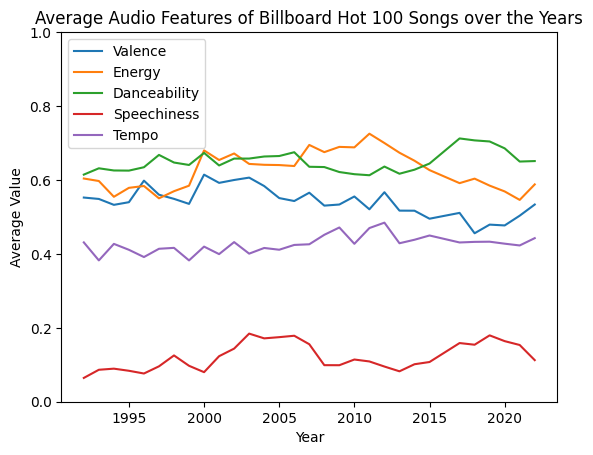

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Expand Audio Features into separate columns
df_expanded = pd.concat([df.drop('Audio Features', axis=1), df['Audio Features'].apply(pd.Series)], axis=1)

# Convert numeric columns to numeric
numeric_columns = ["valence", "energy", "danceability", "speechiness", "tempo"]
df_expanded[numeric_columns] = df_expanded[numeric_columns].apply(pd.to_numeric)

# Normalize all columns to range from 0 to 1
scaler = MinMaxScaler()
df_expanded[numeric_columns] = scaler.fit_transform(df_expanded[numeric_columns])

# Calculate the average values of features by year
average_values_by_year = df_expanded.groupby("Year")[numeric_columns].mean()

# Create line plots for each feature
for column in numeric_columns:
    plt.plot(average_values_by_year.index, average_values_by_year[column], label=column.capitalize())

plt.xlabel("Year")
plt.ylabel("Average Value")
plt.title("Average Audio Features of Billboard Hot 100 Songs over the Years")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis limits to range from 0 to 1
plt.show()


In [ ]:
pip install numpy scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster

# Extract genres
genres = df_expanded["Genres"].explode().unique()

# Create a genre matrix
genre_matrix = pd.DataFrame(0, index=df_expanded.index, columns=genres)

# Assign binary values to the genre matrix
for i, row in df_expanded.iterrows():
    for genre in row["Genres"]:
        genre_matrix.loc[i, genre] = 1

# Calculate pairwise genre similarity
similarity_matrix = cosine_similarity(genre_matrix.T)

# Perform hierarchical clustering
Z = linkage(similarity_matrix, method='ward')

# Set the desired number of clusters
num_clusters = 7

# Assign genres to clusters
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Create a dictionary to store the genres in each cluster
clusters = {
    1: [],  # Soul & Jazz
    2: [],  # Reggae
    3: [],  # Rock & Metal
    4: [],  # Rap & Hip hop
    5: [],  # Pop
    6: [],  # Indie
    7: []   # Other
}

# Assign genres to respective clusters
for genre, cluster_label in zip(genres, cluster_labels):
    if not isinstance(genre, float):
        genre_lower = genre.lower()
        if "pop" in genre_lower:
            clusters[5].append(str(genre))  # Move "pop" genres to Cluster 5
        elif "rap" in genre_lower or "hip hop" in genre_lower:
            clusters[4].append(str(genre))  # Move "rap" and "hip hop" genres to Cluster 4
        elif "rock" in genre_lower or "metal" in genre_lower:
            clusters[3].append(str(genre))  # Move "rock" and "metal" genres to Cluster 3
        elif "reggae" in genre_lower:
            clusters[2].append(str(genre))  # Move "reggae" genres to Cluster 2
        elif "soul" in genre_lower or "jazz" in genre_lower:
            clusters[1].append(str(genre))  # Move "soul" and "jazz" genres to Cluster 1
        elif "indie" in genre_lower:
            clusters[6].append(str(genre))  # Move "indie" genres to Cluster 6
        else:
            clusters[7].append(str(genre))  # Move other genres to Cluster 7

# Print the genres in each cluster
for cluster_id, genre_list in clusters.items():
    cluster_name = {
        1: "Soul & Jazz",
        2: "Reggae",
        3: "Rock & Metal",
        4: "Rap & Hip hop",
        5: "Pop",
        6: "Indie",
        7: "Other"
    }
    print(f"Cluster {cluster_id}: {cluster_name[cluster_id]} - {', '.join(genre_list)}")


Cluster 1: Soul & Jazz - soul, neo soul, smooth jazz, acid jazz, british soul, northern soul, indie soul, classic soul, jazz blues, memphis soul, southern soul, vocal jazz, contemporary vocal jazz, bedroom soul
Cluster 2: Reggae - reggae fusion, uk reggae, reggae, reggaeton, roots reggae, reggae maghreb, reggaeton flow, virgin islands reggae, reggaeton colombiano, modern reggae
Cluster 3: Rock & Metal - album rock, blues rock, classic rock, rock, soft rock, alternative rock, funk metal, funk rock, glam metal, hard rock, country rock, classic canadian rock, glam rock, piano rock, gothenburg metal, metal, power metal, speed metal, swedish power metal, symphonic metal, art rock, progressive rock, symphonic rock, irish rock, heartland rock, folk rock, celtic rock, scottish rock, dance rock, noise rock, comic metal, canadian rock, rock drums, rock-and-roll, rockabilly, alternative metal, industrial metal, industrial rock, thrash metal, groove metal, nu metal, mexican classic rock, southern 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster

# Extract genres
genres = df_expanded["Genres"].explode().unique()

# Create a genre matrix
genre_matrix = pd.DataFrame(0, index=df_expanded.index, columns=genres)

# Assign binary values to the genre matrix
for i, row in df_expanded.iterrows():
    for genre in row["Genres"]:
        genre_matrix.loc[i, genre] = 1

# Calculate pairwise genre similarity
similarity_matrix = cosine_similarity(genre_matrix.T)

# Perform hierarchical clustering
Z = linkage(similarity_matrix, method='ward')

# Set the desired number of clusters
num_clusters = 7

# Assign genres to clusters
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Create a dictionary to store the genres in each cluster
clusters = {
    1: [],  # Soul & Jazz
    2: [],  # Reggae
    3: [],  # Rock & Metal
    4: [],  # Rap & Hip hop
    5: [],  # Pop
    6: [],  # Indie
    7: []   # Other
}

# Assign genres to respective clusters
for genre, cluster_label in zip(genres, cluster_labels):
    if not isinstance(genre, float):
        genre_lower = genre.lower()
        if "pop" in genre_lower:
            clusters[5].append(str(genre))  # Move "pop" genres to Cluster 5
        elif "rap" in genre_lower or "hip hop" in genre_lower:
            clusters[4].append(str(genre))  # Move "rap" and "hip hop" genres to Cluster 4
        elif "rock" in genre_lower or "metal" in genre_lower:
            clusters[3].append(str(genre))  # Move "rock" and "metal" genres to Cluster 3
        elif "reggae" in genre_lower:
            clusters[2].append(str(genre))  # Move "reggae" genres to Cluster 2
        elif "soul" in genre_lower or "jazz" in genre_lower:
            clusters[1].append(str(genre))  # Move "soul" and "jazz" genres to Cluster 1
        elif "indie" in genre_lower:
            clusters[6].append(str(genre))  # Move "indie" genres to Cluster 6
        else:
            clusters[7].append(str(genre))  # Move other genres to Cluster 7

# Create a DataFrame to store the cluster occurrences per year
cluster_occurrences = pd.DataFrame(index=range(start_year, end_year + 1), columns=range(1, num_clusters + 1)).fillna(0)

# Count the occurrences of each cluster per year
for year, cluster_label in zip(all_years, cluster_labels):
    cluster_occurrences.loc[year, cluster_label] += 1

# Select the top two clusters for each year
top_clusters = cluster_occurrences.apply(lambda x: x.nlargest(2).index.tolist(), axis=1)

# Print the year and its corresponding top clusters
for year, top_cluster in top_clusters.items():
    print(f"Year: {year}, Top Clusters: {top_cluster}")


Year: 1992, Top Clusters: [7, 2]
Year: 1993, Top Clusters: [7, 6]
Year: 1994, Top Clusters: [7, 1]
Year: 1995, Top Clusters: [7, 5]
Year: 1996, Top Clusters: [7, 4]
Year: 1997, Top Clusters: [1, 2]
Year: 1998, Top Clusters: [1, 2]
Year: 1999, Top Clusters: [1, 2]
Year: 2000, Top Clusters: [1, 2]
Year: 2001, Top Clusters: [1, 2]
Year: 2002, Top Clusters: [1, 2]
Year: 2003, Top Clusters: [1, 2]
Year: 2004, Top Clusters: [1, 2]
Year: 2005, Top Clusters: [1, 2]
Year: 2006, Top Clusters: [1, 2]
Year: 2007, Top Clusters: [1, 2]
Year: 2008, Top Clusters: [1, 2]
Year: 2009, Top Clusters: [1, 2]
Year: 2010, Top Clusters: [1, 2]
Year: 2011, Top Clusters: [1, 2]
Year: 2012, Top Clusters: [1, 2]
Year: 2013, Top Clusters: [1, 2]
Year: 2014, Top Clusters: [1, 2]
Year: 2015, Top Clusters: [1, 2]
Year: 2016, Top Clusters: [1, 2]
Year: 2017, Top Clusters: [1, 2]
Year: 2018, Top Clusters: [1, 2]
Year: 2019, Top Clusters: [1, 2]
Year: 2020, Top Clusters: [1, 2]
Year: 2021, Top Clusters: [1, 2]
Year: 2022

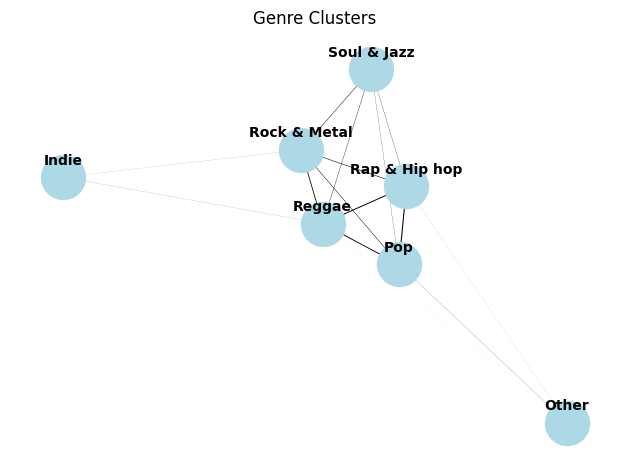

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add nodes for each cluster
for cluster_id, genre_list in clusters.items():
    G.add_node(cluster_id)

# Add edges and their weights based on the genre similarities
for i in range(1, num_clusters + 1):
    for j in range(i + 1, num_clusters + 1):
        similarity = similarity_matrix[i - 1, j - 1]
        G.add_edge(i, j, weight=similarity)

# Set the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(G, seed=42)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)

# Draw the edges
edge_weights = nx.get_edge_attributes(G, 'weight').values()
nx.draw_networkx_edges(G, pos, width=list(edge_weights))

# Add indicative genres as labels to the nodes
indicative_genres = {
    1: "Soul & Jazz",
    2: "Reggae",
    3: "Rock & Metal",
    4: "Rap & Hip hop",
    5: "Pop",
    6: "Indie",
    7: "Other"
}
text_pos = {cluster_id: (x, y+0.05) for cluster_id, (x, y) in pos.items()}  # Adjust the text position to avoid overlapping
nx.draw_networkx_labels(G, text_pos, labels=indicative_genres, font_size=10, font_weight='bold')

# Set plot title and adjust plot layout
plt.title("Genre Clusters")
plt.tight_layout()

# Show the plot
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd

# Count the occurrences of each artist
artist_counts = df['Artist'].value_counts()

# Get the top 5 artists
top_artists = artist_counts.head(5)

# Print the top 5 artists and their counts
print("Top 5 Artists:")
print(top_artists)

# Find the years in which the top artists appear the most
top_artist_years = {}

# Iterate over the top artists
for artist in top_artists.index:
    # Filter the DataFrame for each artist
    artist_df = df[df['Artist'] == artist]
    # Count the occurrences of the artist per year
    artist_year_counts = artist_df['Year'].value_counts()
    # Get the year with the most occurrences
    top_year = artist_year_counts.idxmax()
    # Store the top year for the artist
    top_artist_years[artist] = top_year

# Print the years in which the top artists appear the most
print("\nYears with the most occurrences for each top artist:")
for artist, top_year in top_artist_years.items():
    print(f"{artist}: {top_year}")


Top 5 Artists:
Taylor Swift      24
Mariah Carey      21
Rihanna           20
Pink              19
Kelly Clarkson    17
Name: Artist, dtype: int64

Years with the most occurrences for each top artist:
Taylor Swift: 2015
Mariah Carey: 1992
Rihanna: 2008
Pink: 2002
Kelly Clarkson: 2005


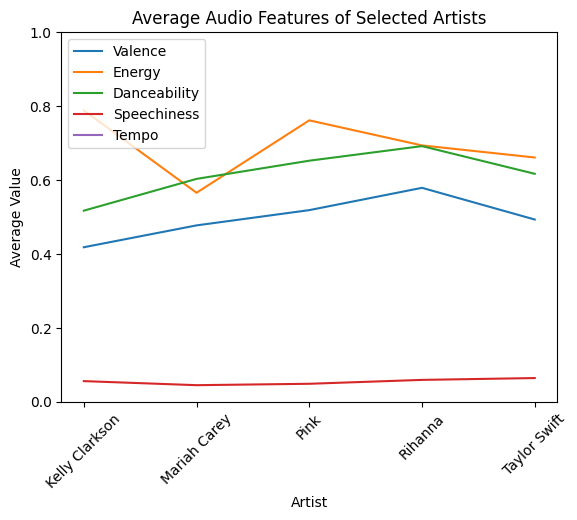

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define the artists to plot
artists = ["Taylor Swift", "Mariah Carey", "Rihanna", "Pink", "Kelly Clarkson"]

# Filter the DataFrame for the specified artists
artist_df = df_expanded[df_expanded['Artist'].isin(artists)]

# Calculate the average values of features by artist
average_values_by_artist = artist_df.groupby("Artist")[numeric_columns].mean()

# Create line plots for each feature
for column in numeric_columns:
    plt.plot(average_values_by_artist.index, average_values_by_artist[column], label=column.capitalize())

plt.xlabel("Artist")
plt.ylabel("Average Value")
plt.title("Average Audio Features of Selected Artists")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis limits to range from 0 to 1
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


<ipython-input-268-5c116ff9d124>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-268-5c116ff9d124>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-268-5c116ff9d124>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-268-5c116ff9d124>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-268-5c116ff9d124>:5: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipyt

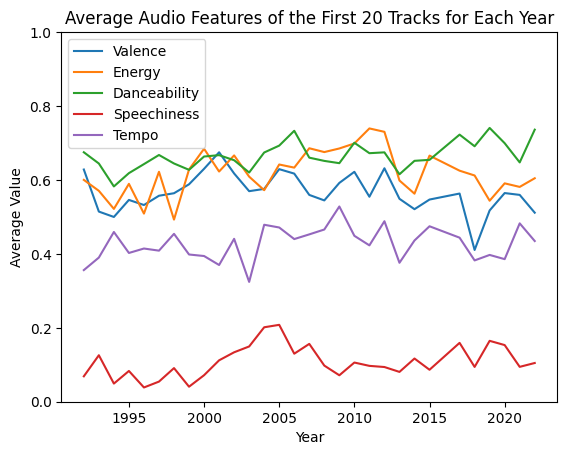

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Expand Audio Features into separate columns
df_expanded = pd.concat([df.drop('Audio Features', axis=1), df['Audio Features'].apply(pd.Series)], axis=1)

# Convert numeric columns to numeric
numeric_columns = ["valence", "energy", "danceability", "speechiness", "tempo"]
df_expanded[numeric_columns] = df_expanded[numeric_columns].apply(pd.to_numeric)

# Normalize all columns to range from 0 to 1
scaler = MinMaxScaler()
df_expanded[numeric_columns] = scaler.fit_transform(df_expanded[numeric_columns])

# Filter the DataFrame for the first 20 tracks of each year
filtered_df = df_expanded.groupby("Year").head(20)

# Calculate the average values of features by year
average_values_by_year = filtered_df.groupby("Year")[numeric_columns].mean()

# Create line plots for each feature
for column in numeric_columns:
    plt.plot(average_values_by_year.index, average_values_by_year[column], label=column.capitalize())

plt.xlabel("Year")
plt.ylabel("Average Value")
plt.title("Average Audio Features of the First 20 Tracks for Each Year")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis limits to range from 0 to 1
plt.show()
